# 4. Random Graph Models (6 points)

- Liam Tessendorf - 20-701-348
- Maximilian von Willich - 17-944-349

### 1 Erdős‐Rényi Model (1 point)
Consider the Erdős‐Rényi G(N, p) model. Generate Erdős‐Rényi graphs with N = 100 nodes for different edge creation probabilities p in the range [0, 1] and plot the probability that a node belongs to the largest connected component (LCC) as N_LCC / N as a function of p. Mark with a vertical line the critical probability p_c = 1/N.

**Hint:** You can use the NetworkX function `nx.erdos_renyi_graph` to produce the graphs. Writing your own function will be judged positively.  
**Hint:** To plot the probability N_LCC / N, you need to average your results by generating many (~100) graphs for each value of p. Use logarithmic spacing for the values of p.



In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
seed = 42
random.seed = seed

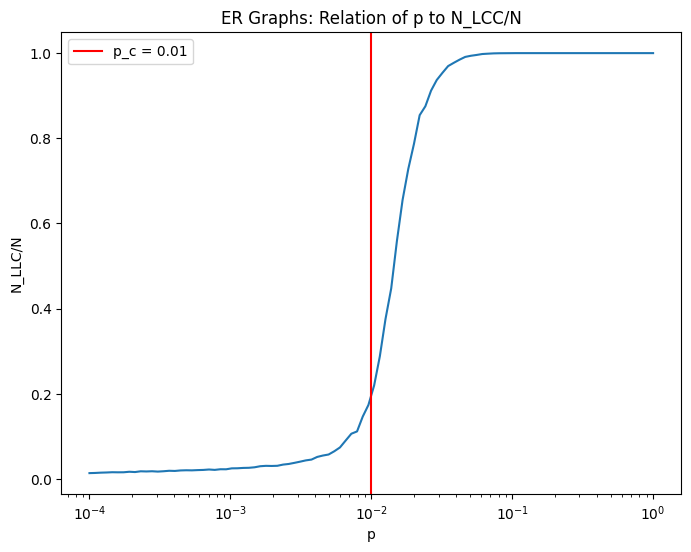

In [3]:
def get_erdos_renyi_graph(n, p):
    # return nx.erdos_renyi_graph(n, p)
    er_graph = nx.Graph()
    nodes = [v for v in range(n)]
    er_graph.add_nodes_from(nodes)
    for v in range(n):
        edges = [(v, w) for w in range(v + 1, n) if random.random() < p]
        er_graph.add_edges_from(edges)
    return er_graph


def get_NLCC_per_N(p, N):
    reps = 100
    N_LCC_sum = 0
    for i in range(reps):
        graph = get_erdos_renyi_graph(N, p)
        N_LCC = len(max(nx.connected_components(graph), key=len))
        N_LCC_sum += N_LCC
    N_LCC_per_N_avg = N_LCC_sum / (reps * N)
    return N_LCC_per_N_avg


def create_data_items_1(N):
    p_values = np.logspace(-4, 0, 100)
    NLLC_values = list()
    for p in p_values:
        NLLC_N = get_NLCC_per_N(p, N)
        NLLC_values.append(NLLC_N)
    return p_values, NLLC_values


def plot_p_vs_NLLC():
    N = 100
    p_values, NLLC_values = create_data_items_1(N)
    p_critical = 1 / N

    plt.figure(figsize=(8, 6))
    plt.plot(p_values, NLLC_values)
    plt.axvline(x=p_critical, color="r", label=f"p_c = {p_critical}")
    plt.legend()
    plt.xscale("log")
    plt.xlabel("p")
    plt.ylabel("N_LLC/N")
    plt.title("ER Graphs: Relation of p to N_LCC/N")
    plt.show()

plot_p_vs_NLLC()

### 2 Clustering and Path Length (1 point)
Generate ER graphs with N = 100 nodes for different edge creation probabilities p in the range [0, 1] and plot the average clustering coefficient (C_avg) and the average path length (d_avg) as a function of p. Provide an interpretation of the result in light of what we discussed during the lecture.


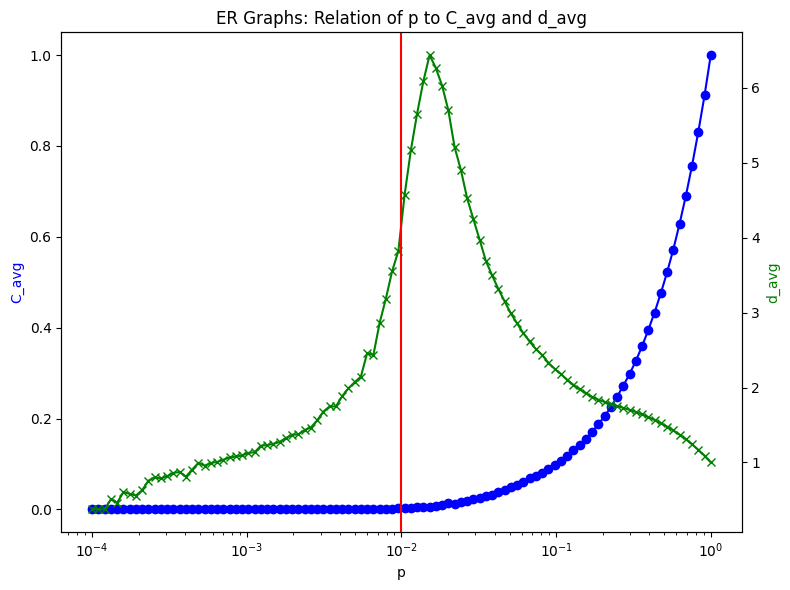

In [4]:
def get_avg_values(N, p):
  reps = 100
  c_sum = 0
  d_avg_sum = 0
  for i in range(reps):
    graph = get_erdos_renyi_graph(N, p)
    c_sum += nx.average_clustering(graph)
    max_comp = max(nx.connected_components(graph), key=len)
    max_comp_graph = graph.subgraph(max_comp)
    d_avg = nx.average_shortest_path_length(max_comp_graph)
    d_avg_sum += d_avg
  c = c_sum/reps
  d = d_avg_sum/reps
  return c, d


def create_data_items_2(N):
  p_values = np.logspace(-4, 0, 100)
  NLLC_values = list()
  c_list = []
  d_list = []
  for p in p_values:
    c_avg, d_avg = get_avg_values(N, p)
    c_list.append(c_avg)
    d_list.append(d_avg)
  return p_values, c_list, d_list


def plot_x_vs_2y(p_values, C_values, d_values, p_critical):
  fig, ax1 = plt.subplots(figsize=(8, 6))

  # plot c_avg on subplot ax1
  ax1.plot(p_values, C_values, 'b', label="C_avg", marker='o')
  ax1.set_xlabel("p")
  ax1.set_xscale('log')
  ax1.set_ylabel("C_avg", color='b')

  # plot d_avg on subplot ax2
  ax2 = ax1.twinx()
  ax2.plot(p_values, d_values, 'g', label="d_avg", marker='x')
  ax2.set_ylabel("d_avg", color='g')

  plt.axvline(x=p_critical, color="r", label=f'p_c = {p_critical}')
  plt.title("ER Graphs: Relation of p to C_avg and d_avg")
  fig.tight_layout()
  plt.show()


def plot_p_vs_C_and_d():
  N = 100
  p_values, c_values, d_values = create_data_items_2(N)
  p_critical = 1/N
  plot_x_vs_2y(p_values, c_values, d_values, p_critical)


plot_p_vs_C_and_d()


### Interpretation
* d_avg is based on the largest component of a graph, since it can't be computed in disconnected graphs.
* d_avg increases with increasing component size. After p_crit Giant Components emerge, which are close in size to N. So d_avg grows until Giant Components are reached. There it reaches its maximum
* Once Giant components are reached, higher p lead to higher connectivity (= C_avg). With higher connectivity d_avg decreases strongly.
* Even around p_crit, where components become gigantic and the connectivity is still low, d_avg at its maximum reaches only up to d_avg = 6, for N = 100. The average shortest paths remain so short because the uniform nature of ER models lead to the small world effect.
* p=1 means that every possible link is created, resulting in a fully connected graph. This clearly leads to d_avg = 1 and c_avg = 1, as supported by the plot.

### 3 One-Dimensional Lattice (1 point)
Write a function to generate a one-dimensional lattice with periodic boundary conditions and coordination number k, as discussed in class and Assignment 1. The function should take two parameters:

- N: the number of nodes of the lattice
- k: the coordination number

The function should output a network (the data structure is your choice). Implement the algorithm yourself without relying on module functions. Finally, produce a visualization of a network generated using this function, with N = 21 and k = 5.

**Hint:** It is recommended to return the network as a `networkx.Graph` object to simplify later points. You can use the NetworkX function `networkx.circular_layout()` for layout.


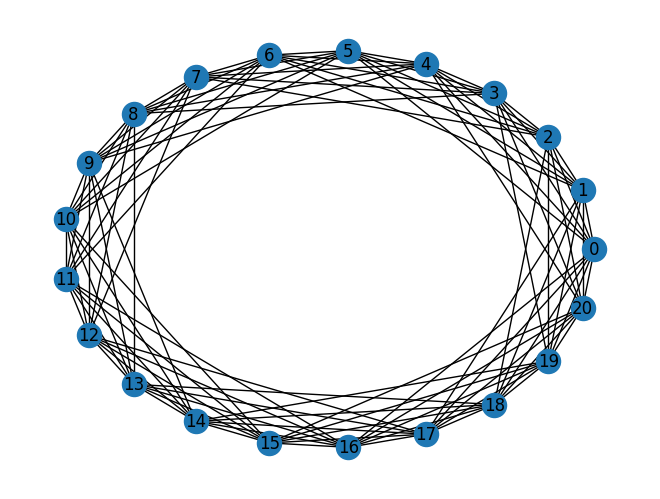

In [5]:
def create_lattice(n, k):
    nodes = [[0 for _ in range(n)] for _ in range(n)]

    for i in range(n):
        for j in range(1, k + 1):
            nodes[i][(i + j) % n] = 1
            nodes[i][(i - j) % n] = 1

    adj_dict = {}
    for i in range(n):
        adj_dict[i] = {}
        for j in range(n):
            if nodes[i][j] == 1:
                adj_dict[i][j] = {}

    G = nx.Graph(adj_dict)

    return G


G = create_lattice(21, 5)
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True)

### 4 Average Path Length (1 point)
Compute the average path length (d_avg) of a sequence of one-dimensional periodic lattices where k = 10 is fixed and the number of nodes N ranges between 50 and 1000. Then, plot d_avg as a function of N. Comment on the relation between d_avg and N.

**Hint:** To calculate the average shortest path length, you can use the NetworkX function `networkx.average_shortest_path_length()`.


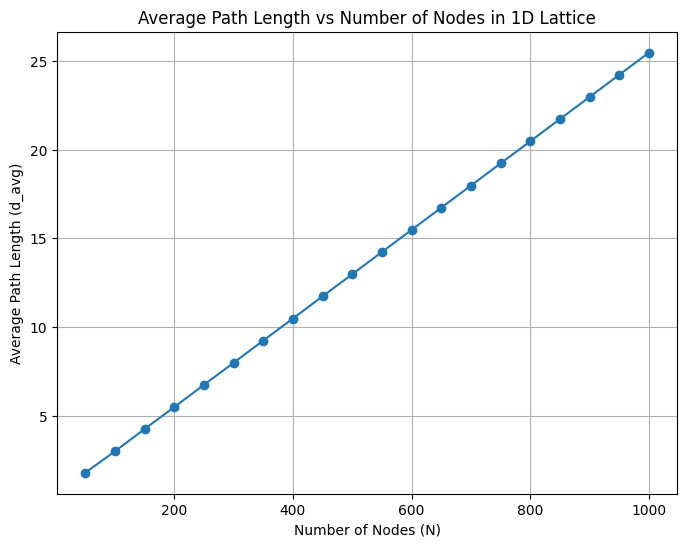

In [6]:
def compute_avg_path_length(N_values, k):
    d_avg_values = []
    for N in N_values:
        lattice = create_lattice(N, k)
        d_avg = nx.average_shortest_path_length(lattice)
        d_avg_values.append(d_avg)
    return d_avg_values


def plot_avg_path_length(N_values, d_avg_values):
    plt.figure(figsize=(8, 6))
    plt.plot(N_values, d_avg_values, marker="o")
    plt.xlabel("Number of Nodes (N)")
    plt.ylabel("Average Path Length (d_avg)")
    plt.title("Average Path Length vs Number of Nodes in 1D Lattice")
    plt.grid(True)
    plt.show()

N_values = range(50, 1001, 50)
k = 10

d_avg_values = compute_avg_path_length(N_values, k)

plot_avg_path_length(N_values, d_avg_values)

### 5 Watts‐Strogatz Model (1 point)
Implement the original Watts‐Strogatz model as seen in the slides. It should take three parameters:

- N: the number of nodes
- k: the coordination number of the 1D original lattice with periodic conditions
- p: the rewiring probability

The function should output a network (the data structure is your choice). Implement the algorithm yourself without relying on NetworkX or third-party modules. Finally, plot the network for N = 21, p = 0.1, and k = 5, using a circular layout.

**Hint:** It is recommended to return the network as a `networkx.Graph` object for simplicity.


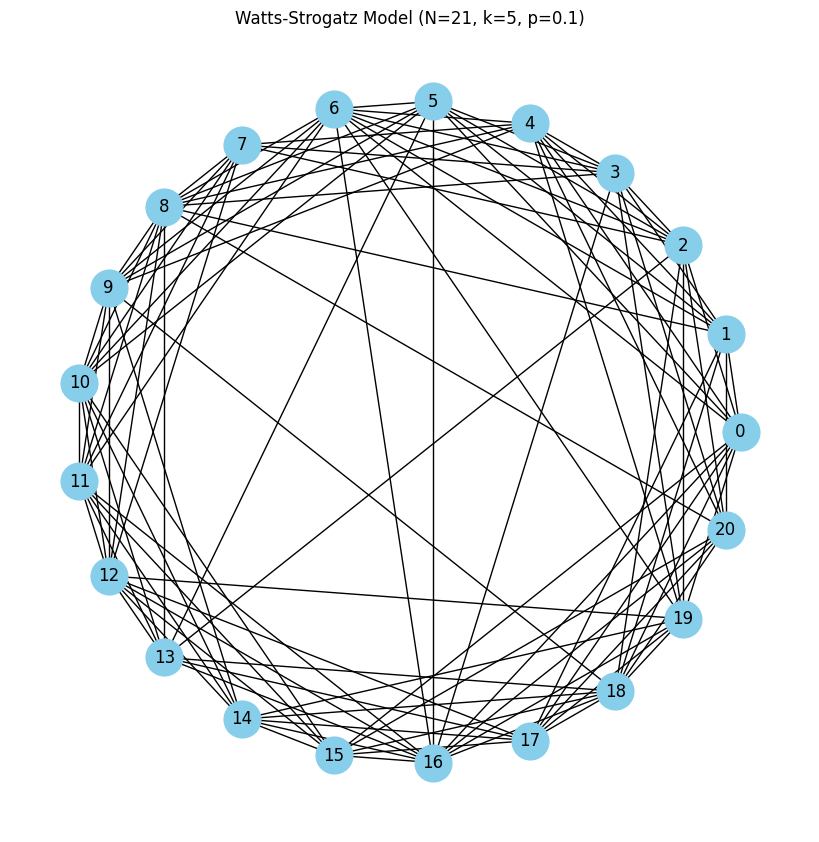

In [7]:
def watts_strogatz_model(N, k, p):
    G = create_lattice(N, k)

    nodes = list(G.nodes)

    for i in range(N):
        for j in range(1, k + 1):
            if random.random() < p:
                while True:
                    new_neighbor = random.choice(nodes)
                    if new_neighbor != i and not G.has_edge(i, new_neighbor):
                        G.remove_edge(i, (i + j) % N)
                        G.add_edge(i, new_neighbor)
                        break
    return G


N = 21
k = 5
p = 0.1

G_ws = watts_strogatz_model(N, k, p)

degrees = [degree for n, degree in G_ws.degree()]
pos = nx.circular_layout(G_ws)
plt.figure(figsize=(8, 8))
nx.draw(
    G_ws, pos, with_labels=True, node_color="skyblue", node_size=700, edge_color="black"
)
plt.title(f"Watts-Strogatz Model (N={N}, k={k}, p={p})")
plt.show()

### 6 Watts‐Strogatz: Clustering and Path Length (1 point)
Compute and plot d_avg and C (the global clustering coefficient) for a sample of networks generated from the Watts‐Strogatz model (using the function from the previous point) as a function of p in the range [0, 1], keeping N = 1000 and k = 10 fixed. Normalize the values using the clustering and average path distance of a one-dimensional lattice with parameters N = 1000 and k = 10, aiming to replicate the "small-world" plot from Watts and Strogatz [1998].

**Hint:** You need to compute d_avg and C as an average over a sample of networks (approx. 10-20 should be enough) for each parameter set.  
**Hint:** Use logarithmic spacing for p.  
**Hint:** NetworkX functions can be used for this exercise, such as `networkx.average_shortest_path_length()` and the function to compute the clustering coefficient.  
**Hint:** Allocate enough time for this item; computations may take time.

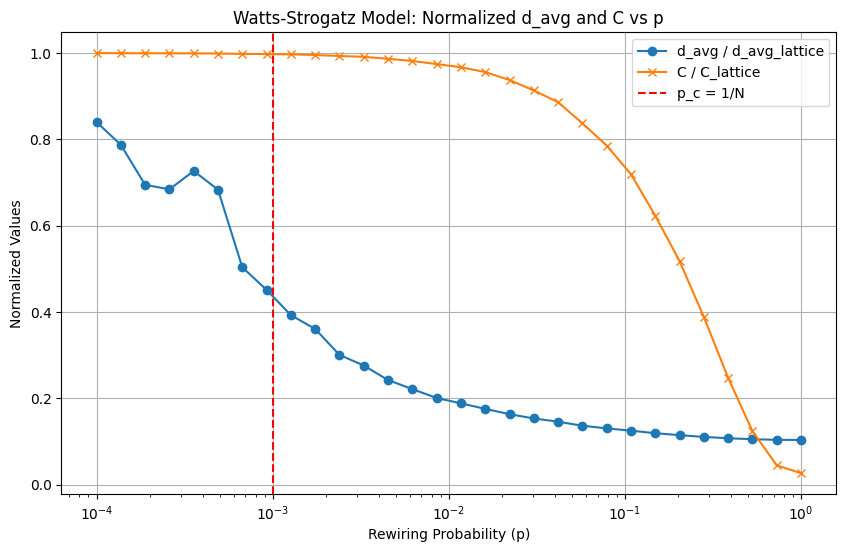

In [8]:
def compute_avg_path_length_and_clustering(N, k, p_values, reps=10):
    d_avg_values = []
    C_values = []
    for p in p_values:
        d_avg_sum = 0
        C_sum = 0
        for _ in range(reps):
            G_ws = watts_strogatz_model(N, k, p)
            d_avg_sum += nx.average_shortest_path_length(G_ws)
            C_sum += nx.average_clustering(G_ws)
        d_avg_values.append(d_avg_sum / reps)
        C_values.append(C_sum / reps)
    return d_avg_values, C_values


def plot_normalized_values(p_values, d_avg_values, C_values, d_avg_lattice, C_lattice):
    plt.figure(figsize=(10, 6))
    plt.plot(
        p_values,
        [d / d_avg_lattice for d in d_avg_values],
        label="d_avg / d_avg_lattice",
        marker="o",
    )
    plt.plot(
        p_values, [C / C_lattice for C in C_values], label="C / C_lattice", marker="x"
    )
    plt.axvline(x=1 / N, color="r", linestyle="--", label="p_c = 1/N")
    plt.xscale("log")
    plt.xlabel("Rewiring Probability (p)")
    plt.ylabel("Normalized Values")
    plt.title("Watts-Strogatz Model: Normalized d_avg and C vs p")
    plt.legend()
    plt.grid(True)
    plt.show()


N = 1000
k = 10
p_values = np.logspace(-4, 0, 30)

lattice = create_lattice(N, k)
d_avg_lattice = nx.average_shortest_path_length(lattice)
C_lattice = nx.average_clustering(lattice)

d_avg_values, C_values = compute_avg_path_length_and_clustering(N, k, p_values)

plot_normalized_values(p_values, d_avg_values, C_values, d_avg_lattice, C_lattice)